In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

In [2]:
data_dir = 'D:/Kaggle/book_train.parquet'
stock_list = os.listdir(data_dir)

In [3]:
len(stock_list)

112

In [4]:
def log_return(stock_price):
    """
    stock price: a series of stock price from groupby function
    """
    return np.log(stock_price).diff()

def realized_vol(stock_log_return):
    """
    log_return: the return of function log_return
    return: the vol of ten mins
    """
    return np.sqrt(np.sum(stock_log_return[1:]**2))

def realized_vol_seconds(stock_log_return,seconds):
    """
    seconds: parameter that controls the target mins
    Designed for feature engineering, the volatility of the last several mins
    """
    return np.sqrt(np.sum(stock_log_return[stock_log_return.seconds_in_bucket >= seconds]['log_return']**2))

def book_train_feature(book_train_0):
    book_train_0['wap1'] = (book_train_0['bid_price1'] * book_train_0['ask_size1']+book_train_0['ask_price1']*book_train_0['bid_size1'])/(book_train_0['bid_size1']+book_train_0['ask_size1'])
    book_train_0['wap2'] = (book_train_0['bid_price2'] * book_train_0['ask_size2']+book_train_0['ask_price2']*book_train_0['bid_size2'])/(book_train_0['bid_size2']+book_train_0['ask_size2'])
    book_train_0['wap_spread'] = book_train_0['wap1'] - book_train_0['wap2']

    book_train_0['bidask_spread'] = (book_train_0['ask_price1'] - book_train_0['bid_price1']) / book_train_0['bid_price1']
    book_train_0['bidask_spread2'] = (book_train_0['ask_price2'] - book_train_0['bid_price2']) / book_train_0['bid_price2']
    # wap在bid和ask之间的范围
    book_train_0['wap_bid_ask_position'] = abs(abs((book_train_0['ask_price2']+book_train_0['ask_price1'])/2-book_train_0['wap1']) - abs((book_train_0['bid_price2']+book_train_0['bid_price1'])/2-book_train_0['wap1']))

    book_train_0['total_ask_size'] = book_train_0['ask_size1'] + book_train_0['ask_size2']
    book_train_0['total_bid_size'] = book_train_0['bid_size1'] + book_train_0['bid_size2']
    book_train_0['total_ask_amount'] = book_train_0['ask_price1'] * book_train_0['ask_size1'] + book_train_0['ask_price2'] * book_train_0['ask_size2']
    book_train_0['total_bid_amount'] = book_train_0['bid_price1'] * book_train_0['bid_size1'] + book_train_0['bid_price2'] * book_train_0['bid_size2']
    book_train_0['size_imbalance'] = book_train_0['total_ask_size'] / book_train_0['total_bid_size'] - 1
    book_train_0['amount_imbalance'] = book_train_0['total_ask_amount'] / book_train_0['total_bid_amount'] - 1

    book_train_0['log_return'] = book_train_0.groupby('time_id')['wap1'].apply(log_return).fillna(0)
    book_train_0['log_return_wap2'] = book_train_0.groupby('time_id')['wap2'].apply(log_return).fillna(0)

    # volatility feature
    list_vol_feature_book = []
    book_train_0_groupby_timeid = book_train_0.groupby('time_id')
    for time_id, book_train_time_id in book_train_0_groupby_timeid:
        # book_train_time_id_numpy = np.array(book_train_time_id)
        realized_vol = realized_vol_seconds(book_train_time_id,seconds=0)
        realized_vol_seconds_300 = realized_vol_seconds(book_train_time_id,seconds=300)
        realized_vol_seconds_480 = realized_vol_seconds(book_train_time_id,seconds=480) 
        realized_vol_seconds_540 = realized_vol_seconds(book_train_time_id,seconds=540)

        book_train_time_id_300 = book_train_time_id[book_train_time_id.seconds_in_bucket>=300]
        book_train_time_id_480 = book_train_time_id[book_train_time_id.seconds_in_bucket>=480]
        book_train_time_id_540 = book_train_time_id[book_train_time_id.seconds_in_bucket>=540]

        wap_spread_cv = book_train_time_id['wap_spread'].std()/book_train_time_id['wap_spread'].mean()
        bidask_spread_range = book_train_time_id['bidask_spread'].quantile(0.75)- book_train_time_id['bidask_spread'].quantile(0.25)
        bidask_spread_cv = book_train_time_id['bidask_spread'].std()/book_train_time_id['bidask_spread'].mean()
        bidask_spread_range2 = book_train_time_id['bidask_spread2'].quantile(0.75)- book_train_time_id['bidask_spread'].quantile(0.25)

        total_ask_size_mean = book_train_time_id['total_ask_size'].mean()
        total_bid_size_mean = book_train_time_id['total_bid_size'].mean()
        total_ask_amount_mean = book_train_time_id['total_ask_amount'].mean()
        total_bid_amount_mean = book_train_time_id['total_bid_amount'].mean()

        # 总体多空情况
        size_imbalance_range = book_train_time_id['size_imbalance'].quantile(0.75) - book_train_time_id['size_imbalance'].quantile(0.25)
        amount_imbalance_range = book_train_time_id['amount_imbalance'].quantile(0.75) - book_train_time_id['amount_imbalance'].quantile(0.25)
        amount_inbalance_cv = book_train_time_id['amount_imbalance'].std()/book_train_time_id['amount_imbalance'].mean()
        total_ask_amount = book_train_time_id['total_ask_amount'].sum()
        total_bid_amount = book_train_time_id['total_bid_amount'].sum()
        total_ask_amount_480 = book_train_time_id_480['total_ask_amount'].sum()
        total_bid_amount_480 = book_train_time_id_480['total_bid_amount'].sum()
        size_imbalance = (book_train_time_id['ask_size1'].sum() - book_train_time_id['bid_size1'].sum())/(book_train_time_id['ask_size1'].sum() + book_train_time_id['bid_size1'].sum())
        # 靠后的时间段多空力量变化
        size_imbalance_seconds_300 = (book_train_time_id_300['ask_size1'].sum() - book_train_time_id_300['bid_size1'].sum())/(book_train_time_id_300['ask_size1'].sum() + book_train_time_id_300['bid_size1'].sum())
        size_imbalance_seconds_480 = (book_train_time_id_480['ask_size1'].sum() - book_train_time_id_480['bid_size1'].sum())/(book_train_time_id_480['ask_size1'].sum() + book_train_time_id_480['bid_size1'].sum())
        size_imbalance_seconds_540 = (book_train_time_id_540['ask_size1'].sum() - book_train_time_id_540['bid_size1'].sum())/(book_train_time_id_540['ask_size1'].sum() + book_train_time_id_540['bid_size1'].sum())

        # wap1的位置
        wap_position = book_train_time_id['wap1'].max()/book_train_time_id['wap1'].iloc[-1] - book_train_time_id['wap1'].iloc[-1]/book_train_time_id['wap1'].min()
        # wap1的震荡范围
        wap_range = book_train_time_id['wap1'].max()/book_train_time_id['wap1'].min()
        wap_range_last_min_ratio = (book_train_time_id_480['wap1'].max()/book_train_time_id_480['wap1'].min())/wap_range
        # wap是否一直处于bid或ask price附近，或代表多空力量差距变化
        wap_bid_ask_imbalance = book_train_time_id['wap_bid_ask_position'].sum()
        wap_bid_ask_imbalance_last_480 =  book_train_time_id_480['wap_bid_ask_position'].sum()
        wap_bid_ask_imbalance_last_540 =  book_train_time_id_540['wap_bid_ask_position'].sum()
        wap_bid_ask_imbalance_range = book_train_time_id['wap_bid_ask_position'].quantile(0.75) -book_train_time_id['wap_bid_ask_position'].quantile(0.25) 

        list_vol_feature_book.append([time_id,realized_vol,realized_vol_seconds_300,realized_vol_seconds_480,realized_vol_seconds_540,bidask_spread_range,bidask_spread_range2,wap_position,wap_bid_ask_imbalance_range,
        bidask_spread_cv,total_ask_size_mean,total_bid_size_mean,total_ask_amount_mean,total_bid_amount_mean,size_imbalance_range,amount_imbalance_range,amount_inbalance_cv,wap_spread_cv,wap_range,wap_range_last_min_ratio,
        wap_bid_ask_imbalance,wap_bid_ask_imbalance_last_480,wap_bid_ask_imbalance_last_540,total_ask_amount,total_bid_amount,size_imbalance,size_imbalance_seconds_300,size_imbalance_seconds_480,size_imbalance_seconds_540,
        total_ask_amount_480,total_bid_amount_480])

    volatility_feature_book = pd.DataFrame(list_vol_feature_book,columns=['time_id','realized_vol','realized_vol_seconds_300','realized_vol_seconds_480','realized_vol_seconds_540','bidask_spread_range','bidask_spread_range2','wap_position','wap_bid_ask_imbalance_range',
        'bidask_spread_cv','total_ask_size_mean','total_bid_size_mean','total_ask_amount_mean','total_bid_amount_mean','size_imbalance_range','amount_imbalance_range','amount_inbalance_cv','wap_spread_cv','wap_range','wap_range_last_min_ratio',
        'wap_bid_ask_imbalance','wap_bid_ask_imbalance_last_480','wap_bid_ask_imbalance_last_540','total_ask_amount','total_bid_amount','size_imbalance','size_imbalance_seconds_300','size_imbalance_seconds_480','size_imbalance_seconds_540',
        'total_ask_amount_480','total_bid_amount_480'])
    return volatility_feature_book


In [5]:
def price_cv_seconds(stock_series,seconds):
    return stock_series[stock_series.seconds_in_bucket >= seconds]

def trade_train_feature(trade_train_0):
    trade_train_0['amount'] = trade_train_0['size'] * trade_train_0['price']
    trade_train_0['avg_order_amount'] = trade_train_0['amount'] / trade_train_0['order_count']


    trade_train_groupby_timeid = trade_train_0.groupby('time_id')
    # feature extraction in trade_train
    list_vol_feature_trade = []
    for time_id,trade_train_time_id in trade_train_groupby_timeid:

        trade_train_time_id_300 = price_cv_seconds(trade_train_time_id,300)
        trade_train_time_id_480 = price_cv_seconds(trade_train_time_id,480)
        trade_train_time_id_540 = price_cv_seconds(trade_train_time_id,540)

        seconds_count = len(trade_train_time_id)
        seconds_count_300 = len(trade_train_time_id_300)
        seconds_count_480 = len(trade_train_time_id_480)
        seconds_count_540 = len(trade_train_time_id_540)

        total_trade_amount = trade_train_time_id['amount'].sum()
        total_trade_amount_300 = trade_train_time_id_300['amount'].sum()
        total_trade_amount_480 = trade_train_time_id_480['amount'].sum()
        total_trade_amount_540 = trade_train_time_id_540['amount'].sum()
        
        total_trade_order = trade_train_time_id['order_count'].sum()
        total_trade_order_300 = trade_train_time_id_300['order_count'].sum()
        total_trade_order_480 = trade_train_time_id_480['order_count'].sum()
        total_trade_order_540 = trade_train_time_id_540['order_count'].sum()

        # 成交价格的震荡区间大小
        price_range = trade_train_time_id['price'].max()/trade_train_time_id['price'].min()
        price_range_last_min_ratio = (trade_train_time_id_540['price'].max()/trade_train_time_id_540['price'].min())/price_range

        # 成交价格所处的10min的位置
        price_position = trade_train_time_id['price'].max()/trade_train_time_id['price'].iloc[-1] - trade_train_time_id['price'].iloc[-1]/trade_train_time_id['price'].min()

        price_std = trade_train_time_id['price'].std()
        price_std_300 = trade_train_time_id_300['price'].std()
        price_std_480 = trade_train_time_id_480['price'].std()
        price_std_540 = trade_train_time_id_540['price'].std()

        price_cv = trade_train_time_id['price'].std()/trade_train_time_id['price'].mean()
        price_cv_300 = trade_train_time_id_300['price'].std()/trade_train_time_id_300['price'].mean()
        price_cv_480 = trade_train_time_id_480['price'].std()/trade_train_time_id_480['price'].mean()
        price_cv_540 = trade_train_time_id_540['price'].std()/trade_train_time_id_540['price'].mean()

        size_cv = trade_train_time_id['size'].std()/trade_train_time_id['size'].mean()
        size_cv_300 = trade_train_time_id_300['size'].std()/trade_train_time_id_300['size'].mean()
        size_cv_540 = trade_train_time_id_540['size'].std()/trade_train_time_id_540['size'].mean()

        # average trade amount
        average_trade_amount = trade_train_time_id['amount'].sum()/trade_train_time_id['order_count'].sum()
        average_trade_order_amount = (trade_train_time_id['amount'] / trade_train_time_id['order_count']).mean()
        average_trade_amount_300 = trade_train_time_id_480['amount'].sum()/trade_train_time_id_300['order_count'].sum()
        average_trade_amount_480 = trade_train_time_id_480['amount'].sum()/trade_train_time_id_480['order_count'].sum()
        average_trade_amount_540 = trade_train_time_id_540['amount'].sum()/trade_train_time_id_540['order_count'].sum()

        list_vol_feature_trade.append([time_id,seconds_count,seconds_count_300,seconds_count_480,seconds_count_540, total_trade_amount,total_trade_amount_300,total_trade_amount_480,total_trade_amount_540,
        total_trade_order, total_trade_order_300,total_trade_order_480,total_trade_order_540,price_range,price_range_last_min_ratio,price_position,price_std,price_std_480,price_std_540,price_std_300,
        price_cv,price_cv_300,price_cv_480,price_cv_540,size_cv,size_cv_300,size_cv_540,average_trade_amount,average_trade_order_amount,average_trade_amount_300,average_trade_amount_480,average_trade_amount_540])

    volatility_feature_trade = pd.DataFrame(list_vol_feature_trade,columns=['time_id','seconds_count','seconds_count_300','seconds_count_480','seconds_count_540', 'total_trade_amount','total_trade_amount_300','total_trade_amount_480','total_trade_amount_540',
        'total_trade_order', 'total_trade_order_300','total_trade_order_480','total_trade_order_540','price_range','price_range_last_min_ratio','price_position','price_std','price_std_480','price_std_540','price_std_300',
        'price_cv','price_cv_300','price_cv_480','price_cv_540','size_cv','size_cv_300','size_cv_540','average_trade_amount','average_trade_order_amount','average_trade_amount_300','average_trade_amount_480','average_trade_amount_540'])
    return volatility_feature_trade

In [ ]:
target_df = pd.read_csv("D:/Kaggle/train.csv")
for stock_id in stock_list[70:112]:
    print(stock_id)
    id_stock = int(stock_id.split('=')[1])
    print(id_stock)
    book_train_0 = pd.read_parquet('D:/Kaggle/book_train.parquet/'+stock_id)
    trade_train_0 = pd.read_parquet('D:/Kaggle/trade_train.parquet/'+stock_id)
    target_df_stock_0 = target_df[target_df.stock_id==id_stock][['time_id','target']]

    volatility_feature = trade_train_feature(trade_train_0).merge(book_train_feature(book_train_0),on='time_id')

    volatility_feature['price_std_540_ratio'] = volatility_feature['price_std_540'] / volatility_feature['price_std']
    volatility_feature['price_std_300_ratio'] = volatility_feature['price_std_300'] / volatility_feature['price_std']
    volatility_feature['price_std_480_ratio'] = volatility_feature['price_std_480'] / volatility_feature['price_std']
    volatility_feature['price_std_480_300_ratio'] = volatility_feature['price_std_480'] / volatility_feature['price_std_300']

    volatility_feature['realized_vol_300_ratio'] = volatility_feature['realized_vol_seconds_300'] / volatility_feature['realized_vol']
    volatility_feature['realized_vol_480_ratio'] = volatility_feature['realized_vol_seconds_480'] / volatility_feature['realized_vol']
    volatility_feature['realized_vol_540_ratio'] = volatility_feature['realized_vol_seconds_540'] / volatility_feature['realized_vol']
    volatility_feature['realized_vol_480_300_ratio'] = volatility_feature['realized_vol_seconds_480'] / volatility_feature['realized_vol_seconds_300']

    volatility_feature['seconds_count_540_ratio'] = volatility_feature['seconds_count_540'] / volatility_feature['seconds_count']
    volatility_feature['seconds_count_300_ratio'] = volatility_feature['seconds_count_300'] / volatility_feature['seconds_count']
    volatility_feature['seconds_count_480_ratio'] = volatility_feature['seconds_count_480'] / volatility_feature['seconds_count']

    volatility_feature['total_trade_amount_540_ratio'] = volatility_feature['total_trade_amount_540'] / volatility_feature['total_trade_amount']
    volatility_feature['total_trade_amount_300_ratio'] = volatility_feature['total_trade_amount_300'] / volatility_feature['total_trade_amount']
    volatility_feature['total_trade_amount_480_ratio'] = volatility_feature['total_trade_amount_480'] / volatility_feature['total_trade_amount']

    volatility_feature['total_trade_order_540_ratio'] = volatility_feature['total_trade_order_540'] / volatility_feature['total_trade_order']
    volatility_feature['total_trade_order_300_ratio'] = volatility_feature['total_trade_order_300'] / volatility_feature['total_trade_order']
    volatility_feature['total_trade_order_480_ratio'] = volatility_feature['total_trade_order_480'] / volatility_feature['total_trade_order']

    volatility_feature['average_trade_amount_300_ratio'] = volatility_feature['average_trade_amount_300'] / volatility_feature['average_trade_amount']
    volatility_feature['average_trade_amount_480_ratio'] = volatility_feature['average_trade_amount_480'] / volatility_feature['average_trade_amount']
    volatility_feature['average_trade_amount_540_ratio'] = volatility_feature['average_trade_amount_540'] / volatility_feature['average_trade_amount']
    
    volatility_feature['stock_id'] = id_stock
    
    train_feature_temp = volatility_feature.merge(target_df_stock_0,on='time_id')
    # train_feature_temp.corr().to_csv('D:/Kaggle/feature/'+stock_id+'_corr.csv')
    train_feature_temp.to_csv('D:/Kaggle/feature/'+stock_id+'.csv')




In [34]:
feature_dir = 'D:/Kaggle/feature'
feature_list = os.listdir(feature_dir)

In [ ]:
feature_train = pd.read_csv('D:/Kaggle/feature/'+feature_list[0])
for feature in feature_list[1:]:
    feature_temp = pd.read_csv('D:/Kaggle/feature/'+feature)
    feature_train = pd.concat([feature_train,feature_temp])
feature_train.describe()

In [38]:
feature_train=feature_train.iloc[:,1:]

In [44]:
feature_train['row-id'] =  feature_train['stock_id'].astype(str) + '-' + feature_train['time_id'].astype(str) 

In [46]:
feature_train.to_csv('D:/Kaggle/feature_train.csv',index=False)

# feature prepocessing

In [7]:
feature_train = pd.read_csv('D:/Kaggle/feature_train.csv')
feature_train = feature_train # 排除time_id-row_id


In [58]:
feature_train = feature_train.iloc[:,:-1]

In [ ]:
feature_train

In [ ]:
feature_train[feature_train.stock_id == 0]


In [ ]:
feature_train[feature_train.stock_id == 70]


In [ ]:
# 标准化
from sklearn.preprocessing import StandardScaler
# feature_train_ = StandardScaler().fit_transform(feature_train)
norm_feature = pd.DataFrame(StandardScaler().fit_transform(feature_train),columns=feature_train.columns)
norm_feature

In [68]:
# 填补缺失值
norm_feature = norm_feature.fillna(method='ffill')
# norm_feature = norm_feature.fillna(method='bfill')

In [ ]:
norm_feature

In [115]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
 
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数
selector = SelectKBest(lambda X, Y: np.array(list(map(lambda x:pearsonr(x, Y), X.T))).T[0], k=30)
selector.fit(norm_feature.iloc[:,:-1], feature_train.iloc[:,-1])

SelectKBest(k=30, score_func=<function <lambda> at 0x00000189B94F8BF8>)

In [ ]:
print(selector.pvalues_)
print(selector.scores_)

In [ ]:
columns_selected = selector.get_support()
columns_selected_list = list(columns_selected)
norm_feature_1 = norm_feature[norm_feature.iloc[:,:-1].columns[columns_selected_list]]
norm_feature_1['target'] = feature_train['target']
norm_feature_1

In [119]:
norm_feature_1.to_csv('D:/Kaggle/feature/norm_feature_1.csv',index=False)

In [9]:
# 给股票添加个人信息
norm_feature_1 = pd.read_csv('D:/Kaggle/feature/norm_feature_1.csv')


In [10]:
norm_feature_1['stock_id'] = feature_train['stock_id']

In [ ]:
norm_feature_1.columns

In [ ]:
norm_feature_groupby = norm_feature_1.groupby('stock_id')
information_stock = []
for stock_id,norm_feature_temp in norm_feature_groupby:
    avg_target_vol = norm_feature_temp['target'].mean()
    iqr_target = norm_feature_temp['target'].quantile(0.75) - norm_feature_temp['target'].quantile(0.25)
    range_target = norm_feature_temp['target'].max() - norm_feature_temp['target'].min()
    information_stock.append([stock_id,avg_target_vol,iqr_target,range_target])
information_stock_df = pd.DataFrame(information_stock,columns=['stock_id','avg_target_vol','iqr_target','range_target'])
information_stock_df

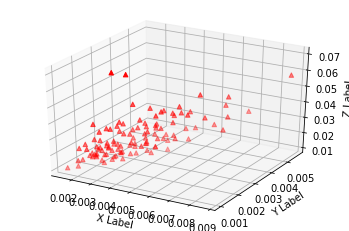

<Figure size 432x288 with 0 Axes>

In [15]:
from sklearn.cluster import kmeans_plusplus

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure().add_subplot(111, projection = '3d')
#zs表示z方向的变量，这三个方向上的变量都可以用list的形式表示
#m表示点的形式，o是圆形的点，^是三角形（marker)
#c表示颜色（color for short）
ax.scatter(information_stock_df['avg_target_vol'], information_stock_df['iqr_target'], information_stock_df['range_target'], c = 'r', marker = '^') #点为红色三角形
 
#设置坐标轴
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
 
#显示图像
plt.show()
 
# ax = plt.figure().add_subplot(111, projection = '3d')
 
fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')
# Calculate seeds from kmeans++
# centers_init, indices = kmeans_plusplus(X, n_clusters=4,random_state=0)


Text(0.5, 1.0, '用肘部法则来确定最佳的K值')

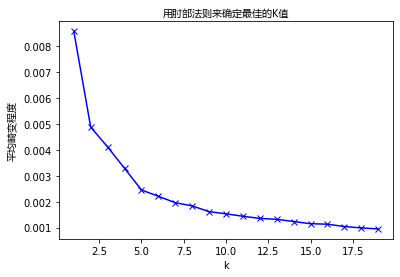

In [18]:
from sklearn.cluster import KMeans
#用scipy求解距离
from scipy.spatial.distance import cdist
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\msyh.ttc", size=10)

K=range(1,20)
meandistortions=[]
for k in K:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(information_stock_df.iloc[:,1:])
    meandistortions.append(sum(np.min(
            cdist(information_stock_df.iloc[:,1:],kmeans.cluster_centers_,
                 'euclidean'),axis=1))/information_stock_df.iloc[:,1:].shape[0])
plt.plot(K,meandistortions,'bx-')
plt.xlabel('k')
plt.ylabel(u'平均畸变程度',fontproperties=font)
plt.title(u'用肘部法则来确定最佳的K值',fontproperties=font)

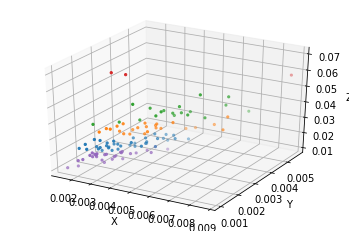

In [24]:
# k-means()
estimator = KMeans(n_clusters = 5)
estimator.fit(information_stock_df.iloc[:,1:])
y_pred = estimator.predict(information_stock_df.iloc[:,1:])

ax = plt.figure().add_subplot(111, projection = '3d')
# ax = Axes3D(fig)
for i in range(5):
    ax.scatter3D(np.array(information_stock_df.iloc[:,1:])[y_pred == i,0],np.array(information_stock_df.iloc[:,1:])[y_pred == i,1],np.array(information_stock_df.iloc[:,1:])[y_pred == i,2],marker = ".")
# ax.view_init(elev = 60,azim = 30)
ax.set_zlabel('Z')
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show()


In [25]:
information_stock_df['classification'] = y_pred

In [ ]:
information_stock_df

In [28]:
information_stock_df.to_csv('D:/Kaggle/model/stock_classification.csv',index=False)

In [30]:
classification = pd.read_csv('D:/Kaggle/model/stock_classification.csv')
check_dict = dict(zip(classification['stock_id'],classification['classification']))

In [ ]:
check_dict